In [1]:
import gym
import scipy.optimize
import roboschool
from agent_file_random_mask import agent
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
np.random.seed(0)
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace")
sns.set(context = "paper", font = "monospace", font_scale=2)

In [2]:
class adversial_env(object):
    def __init__(self, runst=True):
        # parameter
        self.env = gym.make("RoboschoolInvertedPendulum-v1")
        self.env.seed(0)
        self.max_turn = 1000
        self.combine_ratio = 0.05
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = self.env.observation_space
        self.agent = SmallReactivePolicy(self.env.observation_space, self.env.action_space) # declare sample trained agent
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.run_st = runst
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])-0.08#(np.abs(st[3])-0.00786861)*100
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        ac = self.agent.act(a)
        self.obsr, r, done, _ = self.env.step(ac)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done:
            self.first = False
            self.run_avg = self.total_score
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            print(self.run_avg, self.score_list, self.epi_list)
        
        final_r = r 
        
        self.total_score += final_r
        
        
        if self.run_st:
            self.obser_noise = self.obsr
        else:        
            self.obser_noise = (self.obsr*np.random.choice([0, 1],size = [1,5]))[0]
        
        return self.obser_noise, final_r, done, 0
    
    def non_adstep(self, a):
        self.epi_num = self.epi_num + 1
        ac = self.agent.act(a)
        self.obsr, r, done, _ = self.env.step(ac)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done:
            self.first = False
            self.run_avg = self.total_score
        
        final_r = r 
        
        self.total_score += final_r
        
        obser = (self.obsr)
        
        return obser, final_r, done, 0
        
        
    def seed(self, a):
        pass
    
    def reset(self):
        self.obsr = self.env.reset()
        #print(self.total_score)
        self.run_avg = (self.combine_ratio*self.total_score) + (1-self.combine_ratio)*self.run_avg
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.rvg_list.append(self.run_avg)
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    
    def result_plot(self):
        fon_size = 19
        fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1,2,1)
        plt.plot(self.score_list[1:])
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('total reward',fontsize=fon_size)
        #plt.subplot(1,3,2)
        #plt.plot(self.rvg_list[1:])
        #plt.xlabel('episodes')
        #plt.ylabel('running average reward')
        plt.subplot(1,2,2)
        plt.plot(self.epi_list)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('time steps',fontsize=fon_size)
        plt.show()

# performance in adversarial env without observer

In [3]:
env = adversial_env(runst=False)
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        obs, r, done, _ = env.step(obs)
        if done:
            do = True

        score += r

[2018-03-09 06:34:26,172] Making new env: RoboschoolInvertedPendulum-v1


255.0 [255.0] [256]


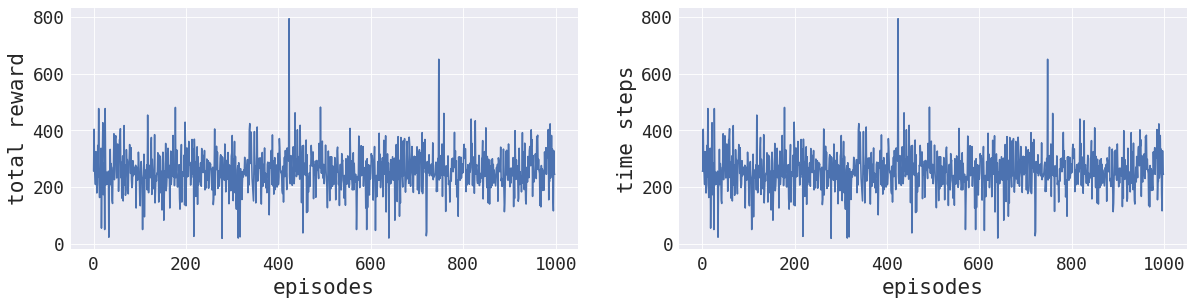

In [4]:
env.result_plot()

# define an observer (new agent)

In [5]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 55000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 999
        
args = par()
env = adversial_env()
agn = agent(env, args)
agn.learn()
agn.save_model('agent_model/random_mask_observer_2')

[2018-03-09 06:35:11,168] Making new env: RoboschoolInvertedPendulum-v1


9.0 [9.0] [10]
Episode 0	Last reward: 25.0	Average reward 21.71
('lagrange multiplier:', 0.9923650629296963, 'grad_norm:', 0.13349826878631363)
fval before 9.073191975546469e-15
a/e/r 0.019714733042859933 0.01984730125859399 0.9933205923562703
fval after -0.01971473304285086
Episode 1	Last reward: 32.0	Average reward 28.02
('lagrange multiplier:', 1.4509394784375336, 'grad_norm:', 0.1966062621152415)
fval before 2.662012876764366e-16
a/e/r 0.032989173810011596 0.02901878956874717 1.1368211527864853
fval after -0.03298917381001133
Episode 2	Last reward: 146.0	Average reward 39.71
('lagrange multiplier:', 1.4488292370317368, 'grad_norm:', 0.2180566880945316)
fval before 1.4722067005053134e-15
a/e/r 0.03188090145659181 0.028976584740635202 1.1002297800776966
fval after -0.03188090145659034
Episode 3	Last reward: 47.0	Average reward 64.40
('lagrange multiplier:', 1.4364674177542023, 'grad_norm:', 0.23856782041711883)
fval before 2.056360883913923e-15
a/e/r 0.029779174783010988 0.0287293483

In [ ]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 55000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 900
        
args = par()
env = adversial_env(runst=False)
agn = agent(env, args)
agn.load_model('agent_model/random_mask_observer_2')

[2018-03-09 06:45:04,150] Making new env: RoboschoolInvertedPendulum-v1


# Agent training

In [ ]:
agn.learn(run_state_update = False) # disable running state update

74.0 [74.0] [75]
Episode 0	Last reward: 172.0	Average reward 67.83
('lagrange multiplier:', 0.5205286188266932, 'grad_norm:', 0.17018207235225888)
fval before -2.2911940813446427e-15
a/e/r 0.010222090717494595 0.01041057679068429 0.9818947521372342
fval after -0.010222090717496886
Episode 1	Last reward: 202.0	Average reward 107.69
('lagrange multiplier:', 0.615848543451722, 'grad_norm:', 0.13887635336251344)
fval before -8.784695228059559e-16
a/e/r 0.011836559414083488 0.012316940903863684 0.9609983117131377
fval after -0.011836559414084366
Episode 2	Last reward: 443.0	Average reward 152.25
('lagrange multiplier:', 0.47272733363814196, 'grad_norm:', 0.10684121321846266)
fval before 2.4027981046175676e-15
a/e/r 0.008811633943407471 0.00945485535802423 0.9319691956925746
fval after -0.008811633943405069
Episode 3	Last reward: 281.0	Average reward 205.04
('lagrange multiplier:', 0.35554383852914145, 'grad_norm:', 0.06221379905582601)
fval before -7.94802681239858e-16
a/e/r 0.0068741928694

In [ ]:
env.result_plot()

# Agent evaluation

In [ ]:
env = adversial_env(runst=False)
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

In [ ]:
env.result_plot()

# Performance on non_adversarial environment with observer

In [ ]:
env = adversial_env()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        
        obs, r, done, _ = env.non_adstep(a)
        if done:
            do = True

        score += r

In [ ]:
env.result_plot()